# TASK IV: Quantum Generative Adversarial Networks (QGANs)


You will explore how best to apply a quantum generative adversarial network (QGAN) to solve a High Energy Data analysis issue, more specifically, separating the signal events from the background events. You should use the Google Cirq and Tensorflow Quantum (TFQ) libraries for this task. 


**Data Description:**

A set of input samples (simulated with Delphes) is provided in NumPy NPZ format https://drive.google.com/file/d/1r_MZB_crfpij6r3SxPDeU_3JD6t6AxAj/view.

In the input file, there are only 100 samples for training and 100 samples for testing so it won’t take much computing resources to accomplish this task. The signal events are labeled with 1 while the background events are labeled with 0. 
Be sure to show that you understand how to fine tune your machine learning model to improve the performance. The performance can be evaluated with classification accuracy or Area Under ROC Curve (AUC). 


In [331]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [332]:
!python --version

Python 3.7.12


In [333]:
!conda list

# packages in environment at /home/lazaror/anaconda3/envs/env37:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                       2_gnu    conda-forge
absl-py                   0.15.0                   pypi_0    pypi
appdirs                   1.4.4                    pypi_0    pypi
astunparse                1.6.3                    pypi_0    pypi
autograd                  1.6.2                    pypi_0    pypi
autoray                   0.6.3                    pypi_0    pypi
backcall                  0.2.0              pyh9f0ad1d_0    conda-forge
ca-certificates           2023.08.22           h06a4308_0    anaconda
cachetools                4.2.4                    pypi_0    pypi
certifi                   2020.6.20          pyhd3eb1b0_3    anaconda
charset-normalizer        3.3.2                    pypi_0    pypi
cirq                      0.11.0             

In [334]:
!pip show cirq

Name: cirq
Version: 0.11.0
Summary: A framework for creating, editing, and invoking Noisy Intermediate Scale Quantum (NISQ) circuits.
Home-page: http://github.com/quantumlib/cirq
Author: The Cirq Developers
Author-email: cirq-dev@googlegroups.com
License: Apache 2
Location: /home/lazaror/anaconda3/envs/env37/lib/python3.7/site-packages
Requires: cirq-core, cirq-google
Required-by: tensorflow-quantum


In [335]:
!pip show tensorflow

Name: tensorflow
Version: 2.4.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /home/lazaror/anaconda3/envs/env37/lib/python3.7/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras-preprocessing, numpy, opt-einsum, protobuf, six, tensorboard, tensorflow-estimator, termcolor, typing-extensions, wheel, wrapt
Required-by: 


In [336]:
!pip show tensorflow-quantum

Name: tensorflow-quantum
Version: 0.5.1
Summary: TensorFlow Quantum is a library for hybrid quantum-classical machine learning.
Home-page: https://github.com/tensorflow/quantum/
Author: Google Inc.
Author-email: no-reply@google.com
License: Apache 2.0
Location: /home/lazaror/anaconda3/envs/env37/lib/python3.7/site-packages
Requires: cirq, google-api-core, google-auth, googleapis-common-protos, protobuf, sympy
Required-by: 


## Load signal/background dataset

In [337]:
# Load the dataset
with np.load('./QIS_EXAM_200Events (1).npz', allow_pickle=True) as data:
    # Extract training and testing inputs
    x_train = data["training_input"].item()
    x_test = data["test_input"].item()

# Extract data for class 0 and class 1 from training and testing sets
x_train_0 = x_train['0']
x_train_1 = x_train['1']
x_test_0 = x_test['0']
x_test_1 = x_test['1']

# Combine data for both classes in the training and testing sets
x_train = np.concatenate((x_train_0, x_train_1), axis=0)
x_test = np.concatenate((x_test_0, x_test_1), axis=0)

# Create labels for training and testing data
y_train = np.zeros((len(x_train),))
y_train[len(x_train_0):] = 1
y_test = np.zeros((len(x_test),))
y_test[len(x_test_0):] = 1

# Print shapes of training and testing data along with their labels
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)


(100, 5) (100,)
(100, 5) (100,)


In [338]:
# convert label format from 1/0 to 1/-1
y_train = tf.keras.utils.to_categorical(y_train)*2-1
y_test = tf.keras.utils.to_categorical(y_test)*2-1

#concatenate a vector of ones
y_train = np.concatenate((y_train, np.ones((len(y_train), 1))), axis=1)
y_test = np.concatenate((y_test, np.ones((len(y_test), 1))), axis=1)


#now, we have used one hot encoding and the labels look like this 
#[0] ---> [ 1,-1, 1]
#[1] ---> [-1, 1, 1]

#the third element is a label to specific real data, it will be useful to distinguish when we are generating fake data.
print(y_train.shape, y_test.shape)

(100, 3) (100, 3)


### QGAN
This model operates with dual objectives: firstly, enabling the discriminator and generator to engage in the fundamental adversarial game, and secondly, empowering the discriminator to proficiently classify signal and background jet events.

Initially, we adopt a quantum perspective for both models. This entails encoding real data into a quantum state, typically achieved through techniques like angle embedding. Subsequently, we construct a quantum generator employing a Parametrized Quantum Circuit (PQC). Likewise, we establish a quantum discriminator utilizing another PQC. This discriminator is tasked with discerning between real and fake data as well as distinguishing between signal and background events.





## Quantum generator Model


### Quantum Generator

The quantum generator is composed of 10 qubits, with the initial 5 qubits designated as data qubits, strategically linked to the quantum discriminator circuit. The remaining qubits function as auxiliary support for the generator's operations.

Each data qubit is subjected to an RY gate operation, with the angle randomly drawn from a normal distribution with mean = 0 and standard deviation = π/3. This ensures that the angles predominantly fall within the range of -π to π. Following this, a sequence of one-qubit unitaries and CNOT gates is applied to entangle neighboring qubits across the entire system. These operations may be iterated across multiple layers. Ultimately, a one-qubit unitary gate is administered to each data qubit at the conclusion of the circuit.

During the training phase of this model, the objective is to refine the quantum generator's ability to fabricate synthetic data that can deceive the quantum discriminator, constituting the real/fake classification task.





In [339]:
def one_qubit_unitary(bit, symbols):
    """Make a Cirq circuit enacting a rotation of the bloch sphere about the X,
    Y and Z axis, that depends on the values in `symbols`.
    """
    return cirq.Circuit(
        cirq.X(bit)**symbols[0],
        cirq.Y(bit)**symbols[1],
        cirq.Z(bit)**symbols[2])


In [340]:
def generator(qubits, symbols, layer=1):
    # Initialize an empty circuit
    circuit = cirq.Circuit()

    # Generate random angles for RY gates
    random_angle = np.random.normal(loc=0, scale=np.pi/3, size=int(len(qubits)/2))

    # Apply RY gates to the first half of qubits with random angles
    for i in range(int(len(qubits)/2)):
        circuit += cirq.ry(random_angle[i])(qubits[i])
    
    # Apply one-qubit unitary operations and CNOT gates for each layer
    for i in range(layer):
        for j in range(len(qubits)):
            # Apply one-qubit unitary gate to each qubit using corresponding symbols
            circuit += one_qubit_unitary(qubits[j], symbols[3*j + 3*i*len(qubits) : 3*(j+1) + 3*i*len(qubits)])
        
        for j in range(len(qubits)):
            # Apply CNOT gate between adjacent qubits
            if j != (len(qubits)-1):
                circuit += cirq.CNOT(qubits[j], qubits[j+1])
    
    # Apply one-qubit unitary gates to the second half of qubits using remaining symbols
    symbols_last_unitary = symbols[-(3*int(len(qubits)/2)):]
    for i in range(int(len(qubits)/2)):
        circuit += one_qubit_unitary(qubits[i], symbols_last_unitary[3*i : 3*(i+1)])

    return circuit


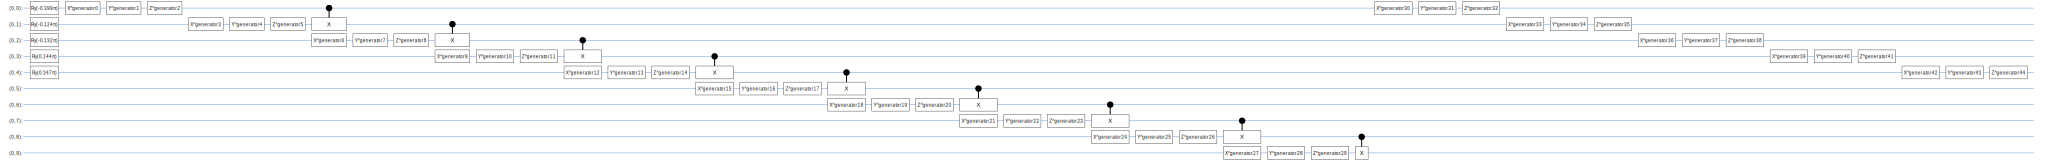

In [341]:
# params total: (3*features*2)*layers + (3*features)
# Note that the first 5 angles are random and therefore not trainable parameters.
SVGCircuit(generator(cirq.GridQubit.rect(1, 10), sympy.symbols('generator:45'), layer=1))

## Quantum Discriminator Model

### Quantum Discriminator

The Quantum Discriminator is composed of 8 qubits. The first 5 qubits correspond to the quantum data, originating either from the generator or real quantum data. The remaining 3 qubits serve as the output for predicting classes. Among these, 2 qubits are dedicated to classifying signal and background events, represented as [C_0, C_1]:

* [1,-1] indicates label 0 (background)
* [-1,1] indicates label 1 (signal)


Meanwhile, the third qubit is employed to classify real and fake data [D]:

* [-1] signifies fake data
* [1] signifies real data

The Quantum Discriminator consists of Hadamard gates and unitary gates with trainable parameters across L layers. Ultimately, measurements are taken from the last 3 qubits to inform the classification outcome.

The structure for the Quantum Discriminator Model is based on reference [2].

In [342]:
def discriminator(data_qubits, output_qubits, symbols, layer=1):
    circuit = cirq.Circuit()

    # Hadamard layer for data qubits
    for i in range(len(data_qubits)):
        circuit += cirq.H(data_qubits[i])
    
    # Combine data and output qubits
    qubits = data_qubits + output_qubits

    # Apply layers
    for i in range(layer):
        # Apply unitary layer
        for j in range(len(qubits)):
            circuit += one_qubit_unitary(qubits[j], symbols[3*j + 3*i*len(qubits) : 3*(j+1) + 3*i*len(qubits)])

        # Apply entangling layer
        for j in range(len(qubits)):
            if j != (len(qubits)-1):
                circuit += cirq.CNOT(qubits[j], qubits[j+1])

    # Apply final unitary for output qubits
    symbols_last_unitary = symbols[-(3*len(output_qubits)):]
    for i in range(len(output_qubits)):
        circuit += one_qubit_unitary(output_qubits[i], symbols_last_unitary[3*i : 3*(i+1)])

    return circuit


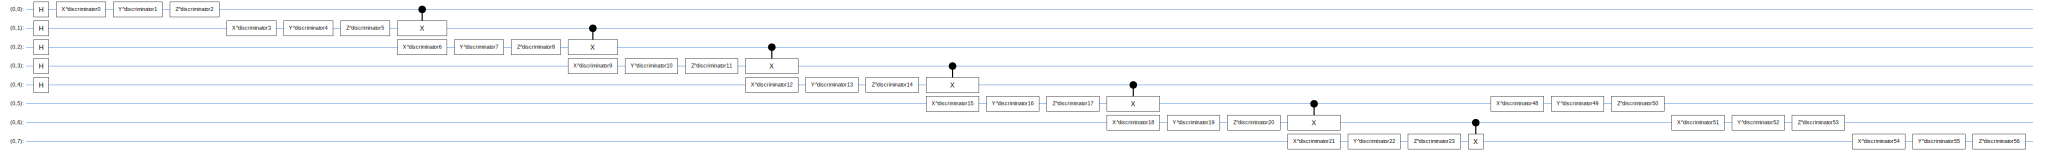

In [343]:
qubits = cirq.GridQubit.rect(1, 8)
# params total: (3 * (features + (2 + 1)))*layer + 3*(2 + 1)
SVGCircuit(discriminator(qubits[0:5], qubits[5:], sympy.symbols('discriminator:57'), layer=1))

## Generator-Discriminator Circuit

Training is crucial in this type of model as it requires a delicate balance between the learning of the generator and discriminator. For this quantum approach and its two classification tasks, we need to divide the training into the following steps:

1. Train the generator-discriminator system.
2. Train the discriminator with real and fake data to classify events.

In step 1, similar to the original Generative Adversarial Networks, we first train one model and freeze the weights of the other. This principle remains valid for this quantum version.

The loss function we aim to minimize is a combination of two classification tasks since we want our model to distinguish between real/fake data and signal/background events. We will employ the same loss functions as those utilized in reference [1].

a) **Discriminator Loss Function**

For this purpose, we use the same discriminator loss function ($L_D$) for the real/fake data task:


$$ L_D = \frac{1}{m_{\text{fake}} + m_{\text{real}}} \left( \sum_{i=1}^{m_{\text{fake}}} \log{(1-D(x_{\text{fake}}^i))} + \sum_{j=1}^{m_{\text{real}}} \log{D(x_{\text{real}}^j)} \right)
 $$
 
Where:

* $m_{\text{fake}}$ and $m_{\text{real}}$ represent the number of samples in the fake (generated) data and real data sets, respectively.
* $x_{\text{fake}}^i$ and $x_{\text{real}}^j$ represent individual samples in the fake (generated) and real data sets, respectively.
* $D(x)$ represents the output of the discriminator for a given input sample $x$. In this case, $D(x_{\text{fake}}^i)$ represents the discriminator's output for the $i$-th fake data sample, and $D(x_{\text{real}}^j)$ represents the discriminator's output for the $j$-th real data sample.
* $\log{(1-D(x_{\text{fake}}^i))}$ and $\log{D(x_{\text{real}}^j)}$ represent the logarithm of the discriminator's output probability for fake and real data samples, respectively. Taking the logarithm scales the values for optimization purposes.

The goal of this loss function is to minimize the negative log probabilities assigned by the discriminator to the fake data samples and maximize the log probabilities assigned to the real data samples.

b) **Classifier Loss Function**

For the second classification task, distinguishing between signal and background events, we define a classification loss function, $L_C$, aiming to minimize errors in this classification. We use a Categorical Cross-Entropy loss function (CE), then,

$$L_C = CE(y_{true}, y_{predict})$$


Where:

* $y_{\text{predict}}$ is the class prediction made by the quantum discriminator, with [1,-1] indicating background and [-1,1] indicating signal.
* $y_{\text{true}}$ is the actual class of the event.


**General Loss Function**


Combining these two loss functions, we can assign a weight to each loss depending on the classification task's importance:

$$
\begin{equation}
    \mathcal{L} = \alpha_{C}L_C + (1-\alpha_C)L_D
\end{equation}
$$
 
Where:

* $\alpha_C$ is a constant value setting the weight of the classifier loss function for signal/background events.
* $L_C$ is the loss function aiming to minimize errors in signal/background data classification.
* $L_D$ is the loss function aiming to minimize errors in real/fake data classification.


Note: The constant $\alpha_C$ allows us to specify the importance of correctly classifying signal/background events. For example:

* If $\alpha_C = 0.0$, our loss function is only $\mathcal{L}=L_D$, meaning we are solely interested in discriminating real/fake data.
* If $\alpha_C = 0.25$, our loss function is $\mathcal{L}= 0.25 L_C + 0.75L_D$, indicating consideration for both loss functions, with a higher priority on correctly classifying real/fake data.
* If $\alpha_C = 0.50$, both loss functions are given equal weight.
* If $\alpha_C = 1$, our loss function is only $\mathcal{L}=L_C$, indicating a full focus on correctly classifying signal/background events.


With this in mind, first, we are going to train our Quantum Discriminator model with $\alpha_C= 0.50$ to get a better performance classifying real/fake data.




In [344]:
def create_gen_disc_circuit(symbols_gen, symbols_disc, qubits, num_features, num_class, gen_layer=1, disc_layer=1):
    # Initialize an empty circuit
    gen_disc_circuit = cirq.Circuit()

    # Add the generator to the circuit
    gen_disc_circuit += generator(qubits[:len(qubits)-(num_class+1)], symbols_gen, layer=gen_layer)
    
    # Add the discriminator to the circuit
    gen_disc_circuit += discriminator(qubits[:int((len(qubits)-(num_class+1))/2)], qubits[len(qubits)-(num_class+1):], symbols_disc, layer=disc_layer)

    return gen_disc_circuit


### Parameters

In [345]:
# model fix parameters

num_class = 2
num_features = 5
gen_layer = 2
disc_layer = 2

total_gen_params = (3*num_features*2)*gen_layer + (3*num_features)
total_disc_params = (3*(num_features + num_class + 1))*disc_layer + 3*(num_class + 1)

print(total_gen_params, total_disc_params)

75 57


In [346]:
# trainable parameters
symbols_gen = sympy.symbols('gen0:' + str(total_gen_params))
symbols_disc = sympy.symbols('disc0:' + str(total_disc_params))

# qubits
qgan_qubits = cirq.GridQubit.rect(1, num_features*2 + num_class + 1)

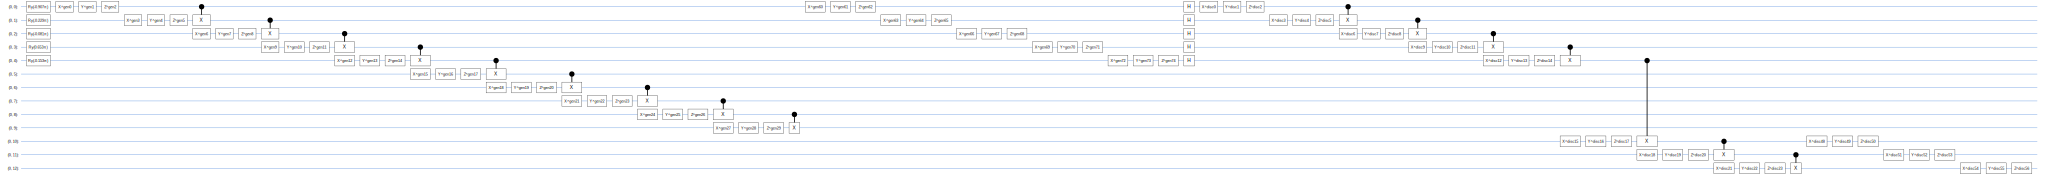

In [347]:
# Define the structure of the General Generator - Discriminator Circuit

# The circuit consists of 13 qubits. The first 10 qubits correspond to the generator model,
# while the first 5 and last 3 qubits correspond to the discriminator model.
# The generator and discriminator are combined using the create_gen_disc_circuit function.

SVGCircuit(create_gen_disc_circuit(symbols_gen, symbols_disc, qgan_qubits, num_features , num_class))


## Utility Functions

### **Model Components and Functions Overview**

In this section, we introduce and explain the key functions and components used in training and evaluating a Quantum Generative Adversarial Network (QGAN) model. These functions play fundamental roles in the training process and in assessing the model's performance. Let's briefly describe each of these functions:

#### Loss functions 
* **Disc_loss**: This function computes the discriminator's loss during training. It evaluates how effectively the discriminator can differentiate between real and fake data, as well as between signal and background events.

* **Gen_loss**: This loss function is used to compute the generator's loss during training. It assesses how well the generator can deceive the discriminator into incorrectly classifying generated data as real.


#### Custom Accuracy function 
* **Custom Accuracy**: This custom metric calculates the accuracy of the discriminator in classifying real and fake data, as well as signal and background events. It provides insight into the discriminator's classification performance.



#### Models
* **Discriminator Model**: This function defines the architecture and operation of the discriminator model. It creates a model that utilizes quantum layers to classify data and calculate the discriminator's loss.

* **Generator Model**: This function defines the architecture and operation of the generator model. It creates a model that uses quantum layers to generate fake data that mimics the distribution of real data.



#### Generating real and fake quantum data

* **Generate Data**: This function generates quantum data using the angle encoding technique. It transforms input data into quantum representations by applying RY gates to each input qubit.

* **Generate Identity**: This function generates identity quantum data, which are direct representations of the input data without any additional transformation.

* **Generate Fake Data**: This function generates fake quantum data using the QGAN model's generator. These fake data are used to train the discriminator and improve its ability to distinguish between real and fake data.


#### Checkpoint 
* **Checkpoint**: This function creates checkpoints during the model training process, allowing the model's weights to be saved to files for later retrieval and reuse.


#### Training functions

* **Train_qgen**: This function trains the generator model using specific input data and computes the generator's loss during training.

* **Train_qdisc**: This function trains the discriminator model using specific input data and computes the discriminator's loss and accuracy during training.

In [348]:
# Set the weight for the classifier loss
alpha_weight = 0.50

# Define a TensorFlow function for computing the discriminator loss
@tf.function
def disc_loss(y_true, y_pred):
    # Extract discriminator predictions for real/fake data
    D_true = (y_true[:, 2] + 1) / 2
    D_pred = (y_pred[:, 2] + 1) / 2

    # Compute the discriminator loss
    D_loss = -1 * (tf.math.log(D_pred + 1e-10) * D_true + tf.math.log(1 - D_pred + 1e-10) * (D_true - 1) * (-1))
    D_loss = tf.reduce_mean(D_loss, axis=0)

    # Extract discriminator predictions for signal/background events
    C_true = (y_true[:, :2] + 1) / 2
    C_pred = (y_pred[:, :2] + 1) / 2

    # Compute the discriminator true size for normalization
    D_true_size = tf.cast(tf.size(tf.where(D_true == 1), out_type=tf.int32), dtype=tf.float32) + 1e-10

    # Compute the classifier loss
    C_loss = tf.math.reduce_sum(tf.keras.losses.CategoricalCrossentropy(reduction='none')(C_true, C_pred) * D_true) / D_true_size

    # Compute the total loss as a combination of discriminator and classifier losses
    return (1 - alpha_weight) * D_loss + alpha_weight * C_loss


We define the custom_accuracy function to calculate the discriminator accuracy in predicting both classification tasks.

In [349]:
# Define a custom accuracy metric using TensorFlow
@tf.function
def custom_accuracy(y_true, y_pred):
    # Extract discriminator predictions for real/fake data
    D_true = (y_true[:, 2] + 1) / 2
    
    # Extract true and predicted labels for signal/background events
    C_real_true = (y_true[:, :2] + 1) / 2
    C_real_pred = (y_pred[:, :2] + 1) / 2

    # Convert one-hot encoded labels to class indices
    C_real_true = tf.math.argmax(C_real_true, axis=1)
    C_real_pred = tf.math.argmax(C_real_pred, axis=1)

    # Calculate the accuracy by comparing true and predicted labels, weighted by D_true
    same = tf.cast(C_real_true == C_real_pred, tf.float32) * D_true

    # Compute the total number of true positive samples (weighted by D_true)
    D_true_size = tf.cast(tf.size(tf.where(D_true == 1), out_type=tf.int32), dtype=tf.float32) + 1e-10

    # Compute the custom accuracy metric by summing the weighted correct predictions and dividing by the total number of true positives
    return tf.math.reduce_sum(same) / D_true_size


In [350]:
# Define the discriminator model for the QGAN

def discriminator_model(weights_disc):
    # Define the readout operators for the discriminator
    disc_readout_operators = [cirq.Z(qgan_qubits[-(num_class+1) + q]) for q in range(num_class+1)]

    # Define the input layer for the data
    data_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)

    # Define the PQC layer for the discriminator
    qdisc_layer = tfq.layers.PQC(discriminator(qgan_qubits[:int((len(qgan_qubits)-(num_class+1))/2)],
                                 qgan_qubits[len(qgan_qubits)-(num_class+1):], weights_disc, layer=disc_layer),
                                 disc_readout_operators, name='qdisc_layer')(data_input)

    # Define the discriminator model using the defined layers
    qdisc_model = tf.keras.Model(inputs=[data_input], outputs=[qdisc_layer])

    # Compile the discriminator model
    qdisc_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                        loss=disc_loss,
                        metrics=[custom_accuracy])

    return qdisc_model

# Create an instance of the discriminator model
qdisc_model = discriminator_model(symbols_disc)

# Plot the architecture of the discriminator model
tf.keras.utils.plot_model(qdisc_model,
                          show_shapes=True,
                          show_layer_names=True,
                          dpi=70)


('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


### Generator Loss function

The generator's loss function is articulated as:

$$L_G = -\frac{1}{m} \sum_{i=1}^{m}\log{D(x_{fake}^i)} $$

where:

* m represents the count of fake data within the batch.

* D signifies the real/fake prediction inferred by the discriminator.


This loss function is proposed in the reference [1] for the quantum generator.

In [351]:
def gen_loss(y_true, y_pred):
    # Scale the predictions to the range [0, 1]
    y_pred = (y_pred + 1) / 2
    
    # Compute the generator loss
    # The generator aims to maximize the probability that the discriminator classifies its output as real (i.e., probability close to 1)
    # Therefore, the loss is calculated as the negative logarithm of the discriminator's probability of classifying the generated data as real
    loss = tf.reduce_mean((-1) * tf.math.log(y_pred), axis=0)
    
    return loss



In [352]:
# Define the generator model for the Generator-Discriminator pair
def generator_model(symbols_gen, weights_disc):
    # Define the readout operators for the generator
    gen_readout_operators = cirq.Z(qgan_qubits[-1])

    # Define the input layer for the data
    data_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)

    # Define the PQC layer for the generator using the generator-discriminator circuit
    qgen_layer = tfq.layers.PQC(create_gen_disc_circuit(symbols_gen, weights_disc,
                                  qgan_qubits, num_features, num_class, gen_layer=gen_layer, disc_layer=disc_layer),
                                  gen_readout_operators, name='qgen_layer')(data_input)

    # Define the generator model using the defined layers
    qgen_model = tf.keras.Model(inputs=[data_input], outputs=[qgen_layer])

    # Compile the generator model
    qgen_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                      loss=gen_loss)

    return qgen_model

# Create an instance of the generator model
qgen_model = generator_model(symbols_gen, qdisc_model.get_weights()[0])

# Plot the architecture of the generator model
tf.keras.utils.plot_model(qgen_model,
                          show_shapes=True,
                          show_layer_names=True,
                          dpi=70)


('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [353]:
qdisc_model.get_weights()[0]

array([1.6743625 , 0.965593  , 4.889253  , 2.3363733 , 3.5613956 ,
       1.9854505 , 1.2182624 , 1.9458052 , 3.9338975 , 3.164249  ,
       2.8624518 , 5.0859337 , 0.694921  , 5.9704466 , 4.5957885 ,
       4.464887  , 4.7960415 , 4.426898  , 2.7739916 , 3.8842103 ,
       3.8008285 , 2.0429792 , 0.5853133 , 2.0590668 , 1.2204151 ,
       5.1736903 , 4.6808295 , 2.4336014 , 1.3291525 , 4.030047  ,
       2.7975032 , 2.2862127 , 3.5689278 , 1.7685571 , 6.0624404 ,
       2.8436687 , 5.535522  , 1.0740465 , 0.49213672, 3.2518537 ,
       5.3378534 , 1.3766347 , 4.77283   , 0.9555892 , 3.9723887 ,
       2.2421243 , 4.884607  , 3.5225728 , 4.5294156 , 4.951722  ,
       5.6566734 , 2.856822  , 5.616181  , 3.118693  , 1.4231814 ,
       4.053533  , 4.426241  ], dtype=float32)

In [354]:
def generate_identity(X):
    """Generate identity quantum data."""
    quantum_data = []  # List to store quantum data circuits
    
    # Iterate through data samples
    for sample in X:
        circuit = cirq.Circuit()  # Create an empty quantum circuit for each sample
        quantum_data.append(circuit)  # Append the empty circuit to the list
        
    return quantum_data  # Return the list of identity quantum data circuits


In [355]:
# Convert generated identity quantum data to TensorFlow Quantum tensors
identity_data = tfq.convert_to_tensor(generate_identity(x_train))

# Create identity labels (all zeros) corresponding to each identity data sample
# this label will be used in the quantum fake data 
identity_label = np.zeros((len(identity_data),))

# Print the lengths of identity data and identity labels for sanity check
print(len(identity_data), identity_label.shape)


100 (100,)


In [356]:
def generate_data(X, qubits):
    """Generate quantum data from the dataset with angle encoding."""
    quantum_data = []  # List to store quantum data circuits
    
    # Iterate through data samples
    for sample in X:
        circuit = cirq.Circuit()  # Create an empty quantum circuit for each sample
        
        # Iterate through the sample's features
        for bit in range(len(sample)):
            # Apply an RY gate to each qubit corresponding to the sample's features
            circuit.append(cirq.ry(sample[bit])(qubits[bit]))
        
        quantum_data.append(circuit)  # Append the quantum circuit representing the sample to the list
        
    return quantum_data  # Return the list of quantum data circuits


In [357]:
train_quantum_data = tfq.convert_to_tensor(generate_data(x_train, qubits))
test_quantum_data = tfq.convert_to_tensor(generate_data(x_test, qubits))

Transform real data into quantum state with angle encoding, this means, one qubit for each feature. 

In [358]:
def generate_fake_data(X, qubits, symbols, layer=1):
    """Generate fake quantum data."""
    quantum_data = []  # List to store fake quantum data circuits
    
    # Iterate through data samples (X is only used to determine the number of fake samples to generate)
    for sample in X:
        # Generate a fake quantum data circuit using the generator model
        # The generator is applied to the specified qubits and with the given symbols and layer
        circuit = generator(qubits[:2 * len(sample)], symbols, layer=layer)
        
        quantum_data.append(circuit)  # Append the generated quantum data circuit to the list
    
    return quantum_data  # Return the list of fake quantum data circuits


In [359]:
# Convert generated fake quantum data to TensorFlow Quantum tensors
fake_data = tfq.convert_to_tensor(generate_fake_data(x_train, qgan_qubits, qgen_model.get_weights()[0], layer=gen_layer))

# Create labels for the fake data
# Initialize an array of zeros for the labels with shape (number of fake data samples, number of classes + 1)
y_true_fake = np.zeros((len(fake_data), num_class + 1))

# Set the third column of the labels to -1, indicating that the data is fake
y_true_fake[:, 2] += (-1)

# Print the shape of the labels for verification
print(y_true_fake.shape)


(100, 3)


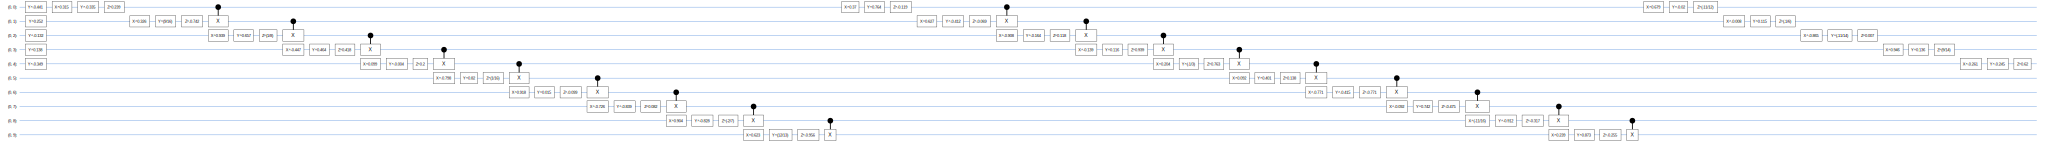

In [360]:
SVGCircuit(tfq.from_tensor(fake_data)[0])

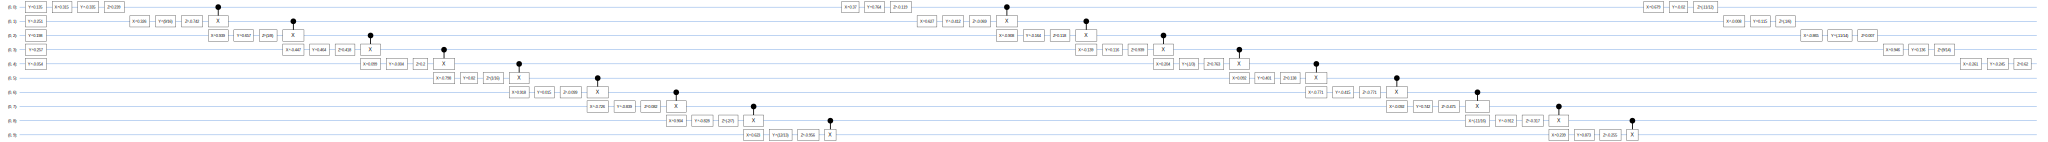

In [361]:
SVGCircuit(tfq.from_tensor(fake_data)[1])

In [362]:
# Initialize the discriminator model using the discriminator model function
qdisc_model = discriminator_model(symbols_disc)

# Initialize the generator model using the generator model function
# The discriminator model weights are passed to the generator model for initialization
qgen_model = generator_model(symbols_gen, qdisc_model.get_weights()[0])


In [363]:
def checkpoints(cycle):
    # Create a model checkpoint callback for the generator model
    gen_model_cp = tf.keras.callbacks.ModelCheckpoint(
        filepath='./model_save/cp_generator1_' + str(cycle) + '.h5',  # Filepath to save the weights
        save_weights_only=True,  # Save only the weights, not the entire model
        monitor='loss',  # Monitor the loss value
        mode='min',  # Mode to determine when to save the weights (minimize loss)
        save_best_only=True  # Save only the best weights based on the monitored quantity
    )

    # Create a model checkpoint callback for the discriminator model
    disc_model_cp = tf.keras.callbacks.ModelCheckpoint(
        filepath='./model_save/cp_disc1_' + str(cycle) + '.h5',  # Filepath to save the weights
        save_weights_only=True,  # Save only the weights, not the entire model
        monitor='custom_accuracy',  # Monitor the custom accuracy metric
        mode='max',  # Mode to determine when to save the weights (maximize custom accuracy)
        save_best_only=True  # Save only the best weights based on the monitored quantity
    )
    
    return gen_model_cp, disc_model_cp  # Return the model checkpoint callbacks


In [364]:
def train_qgen(epochs, batch, verbose):
    # Fit the Generator Model
    history = qgen_model.fit(
        x=identity_data,  # Input data (identity quantum data)
        y=identity_label,  # Target labels
        batch_size=batch,  # Batch size
        epochs=epochs,  # Number of epochs
        verbose=verbose,  # Verbosity mode
        callbacks=[gen_model_cp]  # Callback for saving model checkpoints
    )
    
    return history  # Return training history


In [365]:
def train_qdisc(epochs, batch, verbose):
    # Fit the Discriminator Model
    history = qdisc_model.fit(
        x=gen_data_train,  # Input data (both quantum data for training: real and fake)
        y=y_gen_train,  # Target labels (corresponding labels [1,-1,1], [-1,1,1] for real and [1,-1,0], [-1,1,0] for fake)
        batch_size=batch,  # Batch size
        epochs=epochs,  # Number of epochs
        verbose=verbose,  # Verbosity mode
        callbacks=[disc_model_cp],  # Callback for saving model checkpoints
        validation_data=(gen_data_test, y_gen_test)  # Validation data for monitoring performance
    )
    return history  # Return training history


## First training



In [366]:
# Set the weight for the discriminator loss in the combined loss function
alpha_weight = 0.50

# Retrieve the best weights of the discriminator and generator models
best_qdisc_weights = qdisc_model.get_weights()[0]
best_qgen_weights = qgen_model.get_weights()[0]

# Re-declare the generator model using the weights of the discriminator model
qgen_model = generator_model(symbols_gen, qdisc_model.get_weights()[0])


In [367]:
# Create model checkpoint callbacks for generator and discriminator models
gen_model_cp, disc_model_cp = checkpoints(cycle=1)


In [368]:
# Fit the Generator Model
H = train_qgen(epochs=1000, batch=100, verbose=1)


Epoch 1/1000
1/1 [==============================] - 2s 2s/step - loss: 0.7152
Epoch 2/1000
1/1 [==============================] - 2s 2s/step - loss: 0.7042
Epoch 3/1000
1/1 [==============================] - 1s 1s/step - loss: 0.6936
Epoch 4/1000
1/1 [==============================] - 1s 1s/step - loss: 0.6834
Epoch 5/1000
1/1 [==============================] - 1s 1s/step - loss: 0.6735
Epoch 6/1000
1/1 [==============================] - 2s 2s/step - loss: 0.6639
Epoch 7/1000
1/1 [==============================] - 1s 985ms/step - loss: 0.6546
Epoch 8/1000
1/1 [==============================] - 1s 1s/step - loss: 0.6456
Epoch 9/1000
1/1 [==============================] - 2s 2s/step - loss: 0.6368
Epoch 10/1000
1/1 [==============================] - 1s 1s/step - loss: 0.6283
Epoch 11/1000
1/1 [==============================] - 1s 964ms/step - loss: 0.6200
Epoch 12/1000
1/1 [==============================] - 1s 869ms/step - loss: 0.6118
Epoch 13/1000
1/1 [==============================] -

1/1 [==============================] - 1s 566ms/step - loss: 0.2495
Epoch 102/1000
1/1 [==============================] - 1s 546ms/step - loss: 0.2484
Epoch 103/1000
1/1 [==============================] - 1s 554ms/step - loss: 0.2473
Epoch 104/1000
1/1 [==============================] - 1s 589ms/step - loss: 0.2462
Epoch 105/1000
1/1 [==============================] - 1s 681ms/step - loss: 0.2451
Epoch 106/1000
1/1 [==============================] - 1s 545ms/step - loss: 0.2440
Epoch 107/1000
1/1 [==============================] - 1s 599ms/step - loss: 0.2430
Epoch 108/1000
1/1 [==============================] - 1s 593ms/step - loss: 0.2419
Epoch 109/1000
1/1 [==============================] - 1s 571ms/step - loss: 0.2409
Epoch 110/1000
1/1 [==============================] - 1s 555ms/step - loss: 0.2399
Epoch 111/1000
1/1 [==============================] - 1s 598ms/step - loss: 0.2388
Epoch 112/1000
1/1 [==============================] - 1s 570ms/step - loss: 0.2378
Epoch 113/1000
1/1 

1/1 [==============================] - 0s 499ms/step - loss: 0.1631
Epoch 200/1000
1/1 [==============================] - 1s 565ms/step - loss: 0.1623
Epoch 201/1000
1/1 [==============================] - 1s 603ms/step - loss: 0.1616
Epoch 202/1000
1/1 [==============================] - 1s 590ms/step - loss: 0.1608
Epoch 203/1000
1/1 [==============================] - 1s 553ms/step - loss: 0.1600
Epoch 204/1000
1/1 [==============================] - 1s 527ms/step - loss: 0.1592
Epoch 205/1000
1/1 [==============================] - 1s 559ms/step - loss: 0.1584
Epoch 206/1000
1/1 [==============================] - 1s 560ms/step - loss: 0.1576
Epoch 207/1000
1/1 [==============================] - 1s 522ms/step - loss: 0.1569
Epoch 208/1000
1/1 [==============================] - 1s 520ms/step - loss: 0.1561
Epoch 209/1000
1/1 [==============================] - 1s 582ms/step - loss: 0.1553
Epoch 210/1000
1/1 [==============================] - 1s 595ms/step - loss: 0.1546
Epoch 211/1000
1/1 

1/1 [==============================] - 1s 595ms/step - loss: 0.1079
Epoch 298/1000
1/1 [==============================] - 1s 637ms/step - loss: 0.1076
Epoch 299/1000
1/1 [==============================] - 1s 503ms/step - loss: 0.1073
Epoch 300/1000
1/1 [==============================] - 1s 523ms/step - loss: 0.1071
Epoch 301/1000
1/1 [==============================] - 1s 605ms/step - loss: 0.1068
Epoch 302/1000
1/1 [==============================] - 1s 512ms/step - loss: 0.1065
Epoch 303/1000
1/1 [==============================] - 1s 540ms/step - loss: 0.1062
Epoch 304/1000
1/1 [==============================] - 1s 577ms/step - loss: 0.1059
Epoch 305/1000
1/1 [==============================] - 1s 510ms/step - loss: 0.1057
Epoch 306/1000
1/1 [==============================] - 1s 605ms/step - loss: 0.1054
Epoch 307/1000
1/1 [==============================] - 1s 539ms/step - loss: 0.1052
Epoch 308/1000
1/1 [==============================] - 1s 533ms/step - loss: 0.1049
Epoch 309/1000
1/1 

1/1 [==============================] - 1s 526ms/step - loss: 0.0951
Epoch 396/1000
1/1 [==============================] - 1s 615ms/step - loss: 0.0951
Epoch 397/1000
1/1 [==============================] - 1s 568ms/step - loss: 0.0951
Epoch 398/1000
1/1 [==============================] - 1s 610ms/step - loss: 0.0950
Epoch 399/1000
1/1 [==============================] - 1s 517ms/step - loss: 0.0950
Epoch 400/1000
1/1 [==============================] - 1s 529ms/step - loss: 0.0950
Epoch 401/1000
1/1 [==============================] - 1s 556ms/step - loss: 0.0949
Epoch 402/1000
1/1 [==============================] - 1s 644ms/step - loss: 0.0949
Epoch 403/1000
1/1 [==============================] - 1s 576ms/step - loss: 0.0948
Epoch 404/1000
1/1 [==============================] - 1s 506ms/step - loss: 0.0948
Epoch 405/1000
1/1 [==============================] - 1s 584ms/step - loss: 0.0948
Epoch 406/1000
1/1 [==============================] - 1s 510ms/step - loss: 0.0948
Epoch 407/1000
1/1 

1/1 [==============================] - 1s 624ms/step - loss: 0.0930
Epoch 494/1000
1/1 [==============================] - 1s 578ms/step - loss: 0.0929
Epoch 495/1000
1/1 [==============================] - 1s 561ms/step - loss: 0.0929
Epoch 496/1000
1/1 [==============================] - 1s 564ms/step - loss: 0.0929
Epoch 497/1000
1/1 [==============================] - 1s 581ms/step - loss: 0.0929
Epoch 498/1000
1/1 [==============================] - 1s 572ms/step - loss: 0.0929
Epoch 499/1000
1/1 [==============================] - 1s 540ms/step - loss: 0.0929
Epoch 500/1000
1/1 [==============================] - 1s 536ms/step - loss: 0.0928
Epoch 501/1000
1/1 [==============================] - 1s 588ms/step - loss: 0.0928
Epoch 502/1000
1/1 [==============================] - 1s 693ms/step - loss: 0.0928
Epoch 503/1000
1/1 [==============================] - 1s 560ms/step - loss: 0.0928
Epoch 504/1000
1/1 [==============================] - 1s 560ms/step - loss: 0.0928
Epoch 505/1000
1/1 

1/1 [==============================] - 1s 568ms/step - loss: 0.0915
Epoch 593/1000
1/1 [==============================] - 1s 560ms/step - loss: 0.0915
Epoch 594/1000
1/1 [==============================] - 1s 544ms/step - loss: 0.0915
Epoch 595/1000
1/1 [==============================] - 1s 562ms/step - loss: 0.0915
Epoch 596/1000
1/1 [==============================] - 1s 541ms/step - loss: 0.0915
Epoch 597/1000
1/1 [==============================] - 1s 561ms/step - loss: 0.0915
Epoch 598/1000
1/1 [==============================] - 1s 608ms/step - loss: 0.0915
Epoch 599/1000
1/1 [==============================] - 1s 549ms/step - loss: 0.0914
Epoch 600/1000
1/1 [==============================] - 1s 602ms/step - loss: 0.0914
Epoch 601/1000
1/1 [==============================] - 1s 628ms/step - loss: 0.0914
Epoch 602/1000
1/1 [==============================] - 1s 546ms/step - loss: 0.0914
Epoch 603/1000
1/1 [==============================] - 1s 551ms/step - loss: 0.0914
Epoch 604/1000
1/1 

1/1 [==============================] - 1s 559ms/step - loss: 0.0903
Epoch 691/1000
1/1 [==============================] - 1s 659ms/step - loss: 0.0903
Epoch 692/1000
1/1 [==============================] - 1s 551ms/step - loss: 0.0903
Epoch 693/1000
1/1 [==============================] - 1s 602ms/step - loss: 0.0903
Epoch 694/1000
1/1 [==============================] - 1s 567ms/step - loss: 0.0902
Epoch 695/1000
1/1 [==============================] - 1s 560ms/step - loss: 0.0902
Epoch 696/1000
1/1 [==============================] - 1s 562ms/step - loss: 0.0902
Epoch 697/1000
1/1 [==============================] - 1s 538ms/step - loss: 0.0902
Epoch 698/1000
1/1 [==============================] - 1s 547ms/step - loss: 0.0902
Epoch 699/1000
1/1 [==============================] - 1s 583ms/step - loss: 0.0902
Epoch 700/1000
1/1 [==============================] - 1s 583ms/step - loss: 0.0902
Epoch 701/1000
1/1 [==============================] - 1s 566ms/step - loss: 0.0902
Epoch 702/1000
1/1 

1/1 [==============================] - 1s 562ms/step - loss: 0.0893
Epoch 789/1000
1/1 [==============================] - 1s 589ms/step - loss: 0.0893
Epoch 790/1000
1/1 [==============================] - 1s 522ms/step - loss: 0.0893
Epoch 791/1000
1/1 [==============================] - 1s 553ms/step - loss: 0.0893
Epoch 792/1000
1/1 [==============================] - 1s 566ms/step - loss: 0.0893
Epoch 793/1000
1/1 [==============================] - 1s 565ms/step - loss: 0.0893
Epoch 794/1000
1/1 [==============================] - 1s 590ms/step - loss: 0.0892
Epoch 795/1000
1/1 [==============================] - 1s 605ms/step - loss: 0.0892
Epoch 796/1000
1/1 [==============================] - 1s 555ms/step - loss: 0.0892
Epoch 797/1000
1/1 [==============================] - 1s 557ms/step - loss: 0.0892
Epoch 798/1000
1/1 [==============================] - 1s 555ms/step - loss: 0.0892
Epoch 799/1000
1/1 [==============================] - 1s 518ms/step - loss: 0.0892
Epoch 800/1000
1/1 

1/1 [==============================] - 1s 597ms/step - loss: 0.0887
Epoch 887/1000
1/1 [==============================] - 1s 583ms/step - loss: 0.0887
Epoch 888/1000
1/1 [==============================] - 1s 560ms/step - loss: 0.0886
Epoch 889/1000
1/1 [==============================] - 1s 655ms/step - loss: 0.0886
Epoch 890/1000
1/1 [==============================] - 1s 574ms/step - loss: 0.0886
Epoch 891/1000
1/1 [==============================] - 1s 541ms/step - loss: 0.0886
Epoch 892/1000
1/1 [==============================] - 1s 566ms/step - loss: 0.0886
Epoch 893/1000
1/1 [==============================] - 1s 515ms/step - loss: 0.0886
Epoch 894/1000
1/1 [==============================] - 1s 598ms/step - loss: 0.0886
Epoch 895/1000
1/1 [==============================] - 1s 549ms/step - loss: 0.0886
Epoch 896/1000
1/1 [==============================] - 1s 552ms/step - loss: 0.0886
Epoch 897/1000
1/1 [==============================] - 1s 605ms/step - loss: 0.0886
Epoch 898/1000
1/1 

1/1 [==============================] - 1s 582ms/step - loss: 0.0883
Epoch 985/1000
1/1 [==============================] - 1s 563ms/step - loss: 0.0883
Epoch 986/1000
1/1 [==============================] - 1s 521ms/step - loss: 0.0883
Epoch 987/1000
1/1 [==============================] - 1s 544ms/step - loss: 0.0883
Epoch 988/1000
1/1 [==============================] - 1s 573ms/step - loss: 0.0883
Epoch 989/1000
1/1 [==============================] - 1s 542ms/step - loss: 0.0883
Epoch 990/1000
1/1 [==============================] - 1s 552ms/step - loss: 0.0883
Epoch 991/1000
1/1 [==============================] - 1s 590ms/step - loss: 0.0883
Epoch 992/1000
1/1 [==============================] - 1s 611ms/step - loss: 0.0883
Epoch 993/1000
1/1 [==============================] - 1s 562ms/step - loss: 0.0883
Epoch 994/1000
1/1 [==============================] - 1s 553ms/step - loss: 0.0883
Epoch 995/1000
1/1 [==============================] - 1s 541ms/step - loss: 0.0883
Epoch 996/1000
1/1 

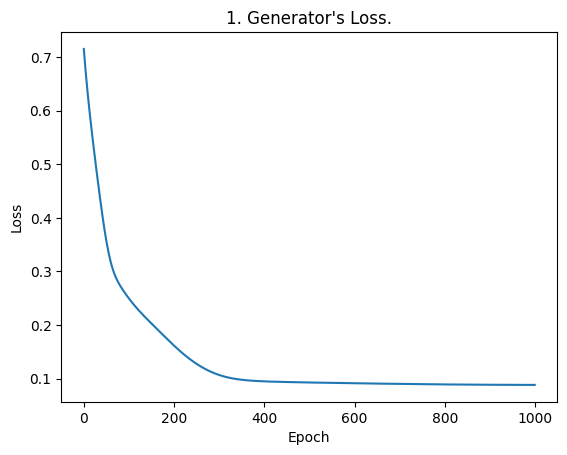

In [369]:
# Plot the generator's loss
plt.plot(H.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("1. Generator's Loss.")
plt.show()

In [370]:
# Generate Real + Fake Data for training and testing sets
gen_data_train = tfq.convert_to_tensor(generate_data(x_train, qgan_qubits) + generate_fake_data(x_train, qgan_qubits, qgen_model.get_weights()[0], layer=gen_layer))
gen_data_test = tfq.convert_to_tensor(generate_data(x_test, qgan_qubits) + generate_fake_data(x_test, qgan_qubits, qgen_model.get_weights()[0], layer=gen_layer))

# Concatenate labels for training and testing sets
y_gen_train = np.concatenate((y_train, y_true_fake), axis=0)
y_gen_test = np.concatenate((y_test, y_true_fake), axis=0)

# Display information about generated data
print("Number of samples in training set:", len(gen_data_train))
print("Number of samples in testing set:", len(gen_data_test))
print("Shapes of labels for training and testing sets:", y_gen_train.shape, y_gen_test.shape)


Number of samples in training set: 200
Number of samples in testing set: 200
Shapes of labels for training and testing sets: (200, 3) (200, 3)


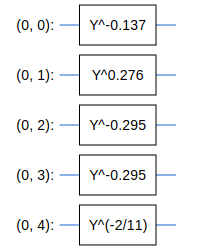

In [371]:
SVGCircuit(tfq.from_tensor(gen_data_train)[0])

In [372]:
# Fit the Discriminator Model
H = train_qdisc(epochs = 200, batch = 64, verbose = 1)

Epoch 1/200
4/4 [==============================] - 2s 400ms/step - loss: 0.7368 - custom_accuracy: 0.3577 - val_loss: 0.5666 - val_custom_accuracy: 0.3016
Epoch 2/200
4/4 [==============================] - 1s 364ms/step - loss: 0.7173 - custom_accuracy: 0.3757 - val_loss: 0.5651 - val_custom_accuracy: 0.3016
Epoch 3/200
4/4 [==============================] - 1s 305ms/step - loss: 0.7201 - custom_accuracy: 0.4058 - val_loss: 0.5639 - val_custom_accuracy: 0.3016
Epoch 4/200
4/4 [==============================] - 1s 296ms/step - loss: 0.6993 - custom_accuracy: 0.4793 - val_loss: 0.5626 - val_custom_accuracy: 0.3016
Epoch 5/200
4/4 [==============================] - 1s 326ms/step - loss: 0.7112 - custom_accuracy: 0.4665 - val_loss: 0.5613 - val_custom_accuracy: 0.3086
Epoch 6/200
4/4 [==============================] - 1s 307ms/step - loss: 0.7080 - custom_accuracy: 0.3937 - val_loss: 0.5602 - val_custom_accuracy: 0.3086
Epoch 7/200
4/4 [==============================] - 1s 296ms/step - los

4/4 [==============================] - 1s 309ms/step - loss: 0.6309 - custom_accuracy: 0.6898 - val_loss: 0.5406 - val_custom_accuracy: 0.3442
Epoch 54/200
4/4 [==============================] - 1s 311ms/step - loss: 0.6609 - custom_accuracy: 0.6309 - val_loss: 0.5407 - val_custom_accuracy: 0.3442
Epoch 55/200
4/4 [==============================] - 1s 294ms/step - loss: 0.6415 - custom_accuracy: 0.6819 - val_loss: 0.5408 - val_custom_accuracy: 0.3442
Epoch 56/200
4/4 [==============================] - 1s 329ms/step - loss: 0.6317 - custom_accuracy: 0.6450 - val_loss: 0.5407 - val_custom_accuracy: 0.3442
Epoch 57/200
4/4 [==============================] - 1s 293ms/step - loss: 0.6322 - custom_accuracy: 0.6463 - val_loss: 0.5405 - val_custom_accuracy: 0.3442
Epoch 58/200
4/4 [==============================] - 1s 290ms/step - loss: 0.6284 - custom_accuracy: 0.6657 - val_loss: 0.5403 - val_custom_accuracy: 0.3442
Epoch 59/200
4/4 [==============================] - 1s 292ms/step - loss: 0.6

4/4 [==============================] - 1s 316ms/step - loss: 0.5977 - custom_accuracy: 0.6845 - val_loss: 0.5024 - val_custom_accuracy: 0.3442
Epoch 106/200
4/4 [==============================] - 1s 300ms/step - loss: 0.6080 - custom_accuracy: 0.6243 - val_loss: 0.5011 - val_custom_accuracy: 0.3442
Epoch 107/200
4/4 [==============================] - 1s 326ms/step - loss: 0.5979 - custom_accuracy: 0.7200 - val_loss: 0.4999 - val_custom_accuracy: 0.3442
Epoch 108/200
4/4 [==============================] - 1s 307ms/step - loss: 0.5997 - custom_accuracy: 0.6428 - val_loss: 0.4986 - val_custom_accuracy: 0.3442
Epoch 109/200
4/4 [==============================] - 1s 346ms/step - loss: 0.5771 - custom_accuracy: 0.7492 - val_loss: 0.4969 - val_custom_accuracy: 0.3442
Epoch 110/200
4/4 [==============================] - 1s 303ms/step - loss: 0.6002 - custom_accuracy: 0.7214 - val_loss: 0.4954 - val_custom_accuracy: 0.3442
Epoch 111/200
4/4 [==============================] - 1s 335ms/step - los

4/4 [==============================] - 1s 311ms/step - loss: 0.5675 - custom_accuracy: 0.6964 - val_loss: 0.4600 - val_custom_accuracy: 0.3442
Epoch 158/200
4/4 [==============================] - 1s 303ms/step - loss: 0.5583 - custom_accuracy: 0.7475 - val_loss: 0.4597 - val_custom_accuracy: 0.3442
Epoch 159/200
4/4 [==============================] - 1s 307ms/step - loss: 0.5771 - custom_accuracy: 0.6870 - val_loss: 0.4593 - val_custom_accuracy: 0.3442
Epoch 160/200
4/4 [==============================] - 1s 329ms/step - loss: 0.5600 - custom_accuracy: 0.7109 - val_loss: 0.4585 - val_custom_accuracy: 0.3442
Epoch 161/200
4/4 [==============================] - 1s 321ms/step - loss: 0.5678 - custom_accuracy: 0.7021 - val_loss: 0.4578 - val_custom_accuracy: 0.3442
Epoch 162/200
4/4 [==============================] - 1s 297ms/step - loss: 0.5771 - custom_accuracy: 0.6931 - val_loss: 0.4577 - val_custom_accuracy: 0.3442
Epoch 163/200
4/4 [==============================] - 1s 321ms/step - los

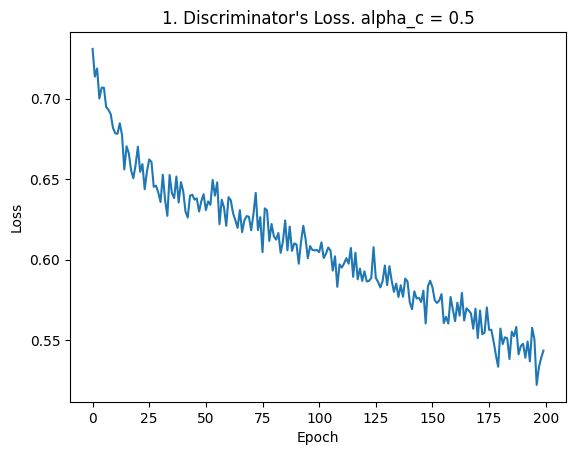

In [373]:
# Plot the discriminator's loss over epochs
plt.plot(H.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("1. Discriminator's Loss. alpha_c = 0.5")
plt.show()

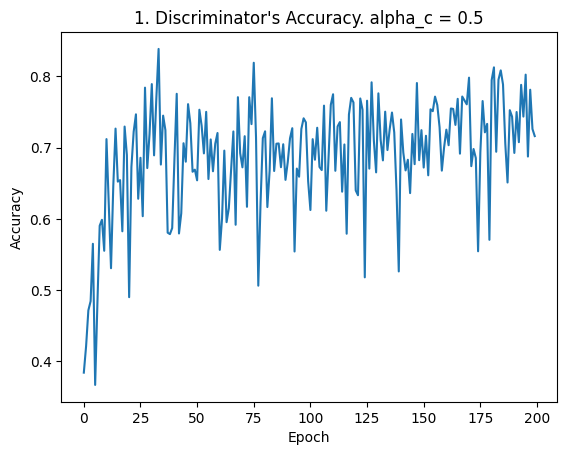

In [374]:
# Plot the discriminator's accuracy over epochs
plt.plot(H.history['custom_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("1. Discriminator's Accuracy. alpha_c = 0.5")
plt.show()

This plot illustrates the discriminator's accuracy in distinguishing between real and fake data, as well as differentiating signal from background events. The model's performance is evaluated across both classification tasks, with equal emphasis on each.

## Second Training

By increasing $\alpha_C$ to $0.75$, we are assigning greater importance to signal/background events over real/fake data classification.

In [376]:
# Update the alpha weight parameter to 0.75
alpha_weight = 0.75

# Retrieve the weights of the discriminator and generator models
best_qdisc_weights = qdisc_model.get_weights()[0]
best_qgen_weights = qgen_model.get_weights()[0]

# Re-declare the generator model using the discriminator's weights
qgen_model = generator_model(symbols_gen, qdisc_model.get_weights()[0])


In [377]:
gen_model_cp, disc_model_cp = checkpoints(cycle=2)

In [378]:
# Fit the Generator Model
H = train_qgen(1000, 100, 1)

Epoch 1/1000
1/1 [==============================] - 1s 830ms/step - loss: 0.8072
Epoch 2/1000
1/1 [==============================] - 1s 570ms/step - loss: 0.8025
Epoch 3/1000
1/1 [==============================] - 1s 603ms/step - loss: 0.7978
Epoch 4/1000
1/1 [==============================] - 1s 564ms/step - loss: 0.7932
Epoch 5/1000
1/1 [==============================] - 1s 568ms/step - loss: 0.7886
Epoch 6/1000
1/1 [==============================] - 1s 609ms/step - loss: 0.7841
Epoch 7/1000
1/1 [==============================] - 1s 625ms/step - loss: 0.7797
Epoch 8/1000
1/1 [==============================] - 1s 581ms/step - loss: 0.7753
Epoch 9/1000
1/1 [==============================] - 1s 610ms/step - loss: 0.7710
Epoch 10/1000
1/1 [==============================] - 1s 597ms/step - loss: 0.7667
Epoch 11/1000
1/1 [==============================] - 1s 692ms/step - loss: 0.7625
Epoch 12/1000
1/1 [==============================] - 1s 648ms/step - loss: 0.7583
Epoch 13/1000
1/1 [======

1/1 [==============================] - 1s 578ms/step - loss: 0.5355
Epoch 102/1000
1/1 [==============================] - 1s 574ms/step - loss: 0.5342
Epoch 103/1000
1/1 [==============================] - 1s 622ms/step - loss: 0.5329
Epoch 104/1000
1/1 [==============================] - 1s 605ms/step - loss: 0.5317
Epoch 105/1000
1/1 [==============================] - 1s 707ms/step - loss: 0.5304
Epoch 106/1000
1/1 [==============================] - 1s 633ms/step - loss: 0.5291
Epoch 107/1000
1/1 [==============================] - 1s 548ms/step - loss: 0.5279
Epoch 108/1000
1/1 [==============================] - 1s 719ms/step - loss: 0.5267
Epoch 109/1000
1/1 [==============================] - 1s 705ms/step - loss: 0.5255
Epoch 110/1000
1/1 [==============================] - 1s 648ms/step - loss: 0.5243
Epoch 111/1000
1/1 [==============================] - 1s 796ms/step - loss: 0.5231
Epoch 112/1000
1/1 [==============================] - 1s 760ms/step - loss: 0.5219
Epoch 113/1000
1/1 

Epoch 200/1000
1/1 [==============================] - 1s 659ms/step - loss: 0.4687
Epoch 201/1000
1/1 [==============================] - 1s 679ms/step - loss: 0.4684
Epoch 202/1000
1/1 [==============================] - 1s 598ms/step - loss: 0.4682
Epoch 203/1000
1/1 [==============================] - 1s 616ms/step - loss: 0.4680
Epoch 204/1000
1/1 [==============================] - 1s 592ms/step - loss: 0.4678
Epoch 205/1000
1/1 [==============================] - 1s 571ms/step - loss: 0.4676
Epoch 206/1000
1/1 [==============================] - 1s 566ms/step - loss: 0.4674
Epoch 207/1000
1/1 [==============================] - 1s 573ms/step - loss: 0.4672
Epoch 208/1000
1/1 [==============================] - 1s 570ms/step - loss: 0.4670
Epoch 209/1000
1/1 [==============================] - 1s 693ms/step - loss: 0.4668
Epoch 210/1000
1/1 [==============================] - 1s 590ms/step - loss: 0.4666
Epoch 211/1000
1/1 [==============================] - 1s 734ms/step - loss: 0.4664
Epoc

1/1 [==============================] - 1s 602ms/step - loss: 0.4568
Epoch 299/1000
1/1 [==============================] - 1s 672ms/step - loss: 0.4567
Epoch 300/1000
1/1 [==============================] - 1s 589ms/step - loss: 0.4567
Epoch 301/1000
1/1 [==============================] - 1s 558ms/step - loss: 0.4566
Epoch 302/1000
1/1 [==============================] - 1s 583ms/step - loss: 0.4565
Epoch 303/1000
1/1 [==============================] - 1s 648ms/step - loss: 0.4565
Epoch 304/1000
1/1 [==============================] - 1s 631ms/step - loss: 0.4564
Epoch 305/1000
1/1 [==============================] - 1s 594ms/step - loss: 0.4563
Epoch 306/1000
1/1 [==============================] - 1s 653ms/step - loss: 0.4563
Epoch 307/1000
1/1 [==============================] - 1s 670ms/step - loss: 0.4562
Epoch 308/1000
1/1 [==============================] - 1s 635ms/step - loss: 0.4562
Epoch 309/1000
1/1 [==============================] - 1s 591ms/step - loss: 0.4561
Epoch 310/1000
1/1 

1/1 [==============================] - 1s 722ms/step - loss: 0.4526
Epoch 397/1000
1/1 [==============================] - 1s 705ms/step - loss: 0.4526
Epoch 398/1000
1/1 [==============================] - 1s 569ms/step - loss: 0.4526
Epoch 399/1000
1/1 [==============================] - 1s 559ms/step - loss: 0.4526
Epoch 400/1000
1/1 [==============================] - 1s 593ms/step - loss: 0.4525
Epoch 401/1000
1/1 [==============================] - 1s 584ms/step - loss: 0.4525
Epoch 402/1000
1/1 [==============================] - 1s 569ms/step - loss: 0.4525
Epoch 403/1000
1/1 [==============================] - 1s 583ms/step - loss: 0.4525
Epoch 404/1000
1/1 [==============================] - 1s 665ms/step - loss: 0.4524
Epoch 405/1000
1/1 [==============================] - 1s 590ms/step - loss: 0.4524
Epoch 406/1000
1/1 [==============================] - 1s 587ms/step - loss: 0.4524
Epoch 407/1000
1/1 [==============================] - 1s 592ms/step - loss: 0.4524
Epoch 408/1000
1/1 

1/1 [==============================] - 1s 577ms/step - loss: 0.4507
Epoch 495/1000
1/1 [==============================] - 1s 634ms/step - loss: 0.4507
Epoch 496/1000
1/1 [==============================] - 1s 580ms/step - loss: 0.4507
Epoch 497/1000
1/1 [==============================] - 1s 584ms/step - loss: 0.4506
Epoch 498/1000
1/1 [==============================] - 1s 663ms/step - loss: 0.4506
Epoch 499/1000
1/1 [==============================] - 1s 705ms/step - loss: 0.4506
Epoch 500/1000
1/1 [==============================] - 1s 600ms/step - loss: 0.4506
Epoch 501/1000
1/1 [==============================] - 1s 587ms/step - loss: 0.4506
Epoch 502/1000
1/1 [==============================] - 1s 574ms/step - loss: 0.4506
Epoch 503/1000
1/1 [==============================] - 1s 591ms/step - loss: 0.4506
Epoch 504/1000
1/1 [==============================] - 1s 577ms/step - loss: 0.4506
Epoch 505/1000
1/1 [==============================] - 1s 560ms/step - loss: 0.4505
Epoch 506/1000
1/1 

1/1 [==============================] - 1s 636ms/step - loss: 0.4497
Epoch 593/1000
1/1 [==============================] - 1s 722ms/step - loss: 0.4497
Epoch 594/1000
1/1 [==============================] - 1s 782ms/step - loss: 0.4497
Epoch 595/1000
1/1 [==============================] - 1s 594ms/step - loss: 0.4497
Epoch 596/1000
1/1 [==============================] - 1s 601ms/step - loss: 0.4497
Epoch 597/1000
1/1 [==============================] - 1s 583ms/step - loss: 0.4497
Epoch 598/1000
1/1 [==============================] - 1s 578ms/step - loss: 0.4497
Epoch 599/1000
1/1 [==============================] - 1s 645ms/step - loss: 0.4496
Epoch 600/1000
1/1 [==============================] - 1s 564ms/step - loss: 0.4496
Epoch 601/1000
1/1 [==============================] - 1s 696ms/step - loss: 0.4496
Epoch 602/1000
1/1 [==============================] - 1s 1s/step - loss: 0.4496
Epoch 603/1000
1/1 [==============================] - 1s 1s/step - loss: 0.4496
Epoch 604/1000
1/1 [=====

1/1 [==============================] - 1s 1s/step - loss: 0.4492
Epoch 694/1000
1/1 [==============================] - 1s 1s/step - loss: 0.4492
Epoch 695/1000
1/1 [==============================] - 1s 971ms/step - loss: 0.4492
Epoch 696/1000
1/1 [==============================] - 1s 967ms/step - loss: 0.4492
Epoch 697/1000
1/1 [==============================] - 1s 1s/step - loss: 0.4492
Epoch 698/1000
1/1 [==============================] - 2s 2s/step - loss: 0.4492
Epoch 699/1000
1/1 [==============================] - 1s 1s/step - loss: 0.4492
Epoch 700/1000
1/1 [==============================] - 1s 1s/step - loss: 0.4492
Epoch 701/1000
1/1 [==============================] - 1s 1s/step - loss: 0.4491
Epoch 702/1000
1/1 [==============================] - 1s 1s/step - loss: 0.4491
Epoch 703/1000
1/1 [==============================] - 1s 976ms/step - loss: 0.4491
Epoch 704/1000
1/1 [==============================] - 1s 1s/step - loss: 0.4491
Epoch 705/1000
1/1 [==========================

1/1 [==============================] - 1s 1s/step - loss: 0.4489
Epoch 795/1000
1/1 [==============================] - 1s 1s/step - loss: 0.4489
Epoch 796/1000
1/1 [==============================] - 1s 1s/step - loss: 0.4489
Epoch 797/1000
1/1 [==============================] - 1s 1s/step - loss: 0.4489
Epoch 798/1000
1/1 [==============================] - 1s 1s/step - loss: 0.4489
Epoch 799/1000
1/1 [==============================] - 1s 988ms/step - loss: 0.4489
Epoch 800/1000
1/1 [==============================] - 1s 1s/step - loss: 0.4489
Epoch 801/1000
1/1 [==============================] - 1s 1s/step - loss: 0.4489
Epoch 802/1000
1/1 [==============================] - 1s 1s/step - loss: 0.4489
Epoch 803/1000
1/1 [==============================] - 1s 1s/step - loss: 0.4489
Epoch 804/1000
1/1 [==============================] - 1s 1s/step - loss: 0.4489
Epoch 805/1000
1/1 [==============================] - 1s 1s/step - loss: 0.4489
Epoch 806/1000
1/1 [==============================] 

1/1 [==============================] - 1s 582ms/step - loss: 0.4487
Epoch 896/1000
1/1 [==============================] - 1s 708ms/step - loss: 0.4487
Epoch 897/1000
1/1 [==============================] - 1s 634ms/step - loss: 0.4487
Epoch 898/1000
1/1 [==============================] - 1s 621ms/step - loss: 0.4487
Epoch 899/1000
1/1 [==============================] - 1s 618ms/step - loss: 0.4487
Epoch 900/1000
1/1 [==============================] - 1s 679ms/step - loss: 0.4487
Epoch 901/1000
1/1 [==============================] - 1s 640ms/step - loss: 0.4487
Epoch 902/1000
1/1 [==============================] - 1s 590ms/step - loss: 0.4487
Epoch 903/1000
1/1 [==============================] - 1s 595ms/step - loss: 0.4487
Epoch 904/1000
1/1 [==============================] - 1s 752ms/step - loss: 0.4487
Epoch 905/1000
1/1 [==============================] - 1s 618ms/step - loss: 0.4487
Epoch 906/1000
1/1 [==============================] - 1s 602ms/step - loss: 0.4487
Epoch 907/1000
1/1 

1/1 [==============================] - 1s 583ms/step - loss: 0.4486
Epoch 994/1000
1/1 [==============================] - 1s 586ms/step - loss: 0.4486
Epoch 995/1000
1/1 [==============================] - 1s 683ms/step - loss: 0.4486
Epoch 996/1000
1/1 [==============================] - 1s 577ms/step - loss: 0.4486
Epoch 997/1000
1/1 [==============================] - 1s 577ms/step - loss: 0.4486
Epoch 998/1000
1/1 [==============================] - 1s 565ms/step - loss: 0.4486
Epoch 999/1000
1/1 [==============================] - 1s 588ms/step - loss: 0.4486
Epoch 1000/1000
1/1 [==============================] - 1s 573ms/step - loss: 0.4486


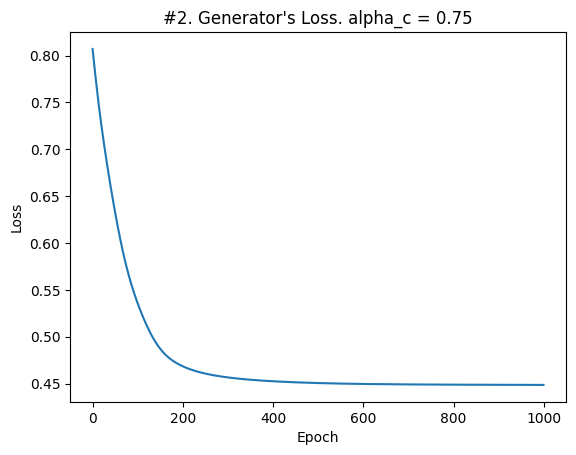

In [379]:
# Plot the generator's loss
plt.plot(H.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("#2. Generator's Loss. alpha_c = 0.75")
plt.show()

In [380]:
# Generate real and fake quantum data for training and testing

# Generate real and fake quantum data for training set
gen_data_train = tfq.convert_to_tensor(generate_data(x_train, qgan_qubits) + generate_fake_data(x_train, qgan_qubits, qgen_model.get_weights()[0], layer=gen_layer))

# Generate real and fake quantum data for testing set
gen_data_test = tfq.convert_to_tensor(generate_data(x_test, qgan_qubits) + generate_fake_data(x_test, qgan_qubits, qgen_model.get_weights()[0], layer=gen_layer))

# Concatenate labels for training and testing sets
y_gen_train = np.concatenate((y_train, y_true_fake), axis=0)
y_gen_test = np.concatenate((y_test, y_true_fake), axis=0)

# Print the lengths of the training and testing data
print("Number of samples in training set:", len(gen_data_train))
print("Number of samples in testing set:", len(gen_data_test))

# Print the shapes of the labels for training and testing sets
print("Shape of labels for training set:", y_gen_train.shape)
print("Shape of labels for testing set:", y_gen_test.shape)


Number of samples in training set: 200
Number of samples in testing set: 200
Shape of labels for training set: (200, 3)
Shape of labels for testing set: (200, 3)


In [381]:
# Fit the Discriminator Model
H = train_qdisc(200, 64, 1)

Epoch 1/200
4/4 [==============================] - 1s 339ms/step - loss: 0.5172 - custom_accuracy: 0.7769 - val_loss: 0.4203 - val_custom_accuracy: 0.3442
Epoch 2/200
4/4 [==============================] - 1s 365ms/step - loss: 0.5279 - custom_accuracy: 0.7337 - val_loss: 0.4195 - val_custom_accuracy: 0.3442
Epoch 3/200
4/4 [==============================] - 1s 327ms/step - loss: 0.5239 - custom_accuracy: 0.7226 - val_loss: 0.4194 - val_custom_accuracy: 0.3442
Epoch 4/200
4/4 [==============================] - 1s 320ms/step - loss: 0.5317 - custom_accuracy: 0.7502 - val_loss: 0.4210 - val_custom_accuracy: 0.3442
Epoch 5/200
4/4 [==============================] - 1s 311ms/step - loss: 0.5265 - custom_accuracy: 0.7330 - val_loss: 0.4211 - val_custom_accuracy: 0.3442
Epoch 6/200
4/4 [==============================] - 1s 349ms/step - loss: 0.5355 - custom_accuracy: 0.6546 - val_loss: 0.4198 - val_custom_accuracy: 0.3442
Epoch 7/200
4/4 [==============================] - 1s 308ms/step - los

4/4 [==============================] - 1s 314ms/step - loss: 0.4839 - custom_accuracy: 0.7518 - val_loss: 0.3962 - val_custom_accuracy: 0.3442
Epoch 54/200
4/4 [==============================] - 1s 302ms/step - loss: 0.4792 - custom_accuracy: 0.7149 - val_loss: 0.3955 - val_custom_accuracy: 0.3442
Epoch 55/200
4/4 [==============================] - 1s 333ms/step - loss: 0.4873 - custom_accuracy: 0.6979 - val_loss: 0.3939 - val_custom_accuracy: 0.3442
Epoch 56/200
4/4 [==============================] - 1s 358ms/step - loss: 0.4848 - custom_accuracy: 0.7398 - val_loss: 0.3935 - val_custom_accuracy: 0.3442
Epoch 57/200
4/4 [==============================] - 1s 315ms/step - loss: 0.4947 - custom_accuracy: 0.6748 - val_loss: 0.3931 - val_custom_accuracy: 0.3442
Epoch 58/200
4/4 [==============================] - 1s 304ms/step - loss: 0.4850 - custom_accuracy: 0.6826 - val_loss: 0.3928 - val_custom_accuracy: 0.3442
Epoch 59/200
4/4 [==============================] - 1s 329ms/step - loss: 0.4

4/4 [==============================] - 1s 324ms/step - loss: 0.4831 - custom_accuracy: 0.7290 - val_loss: 0.3864 - val_custom_accuracy: 0.3442
Epoch 106/200
4/4 [==============================] - 1s 320ms/step - loss: 0.4943 - custom_accuracy: 0.6447 - val_loss: 0.3860 - val_custom_accuracy: 0.3442
Epoch 107/200
4/4 [==============================] - 1s 311ms/step - loss: 0.4877 - custom_accuracy: 0.6752 - val_loss: 0.3867 - val_custom_accuracy: 0.3442
Epoch 108/200
4/4 [==============================] - 1s 345ms/step - loss: 0.4724 - custom_accuracy: 0.7566 - val_loss: 0.3871 - val_custom_accuracy: 0.3442
Epoch 109/200
4/4 [==============================] - 1s 322ms/step - loss: 0.4861 - custom_accuracy: 0.7112 - val_loss: 0.3878 - val_custom_accuracy: 0.3442
Epoch 110/200
4/4 [==============================] - 1s 317ms/step - loss: 0.4899 - custom_accuracy: 0.6303 - val_loss: 0.3886 - val_custom_accuracy: 0.3442
Epoch 111/200
4/4 [==============================] - 1s 311ms/step - los

4/4 [==============================] - 1s 340ms/step - loss: 0.4712 - custom_accuracy: 0.6689 - val_loss: 0.3728 - val_custom_accuracy: 0.3442
Epoch 158/200
4/4 [==============================] - 1s 319ms/step - loss: 0.4691 - custom_accuracy: 0.6330 - val_loss: 0.3724 - val_custom_accuracy: 0.3442
Epoch 159/200
4/4 [==============================] - 1s 319ms/step - loss: 0.4704 - custom_accuracy: 0.7339 - val_loss: 0.3707 - val_custom_accuracy: 0.3442
Epoch 160/200
4/4 [==============================] - 1s 360ms/step - loss: 0.4688 - custom_accuracy: 0.7338 - val_loss: 0.3704 - val_custom_accuracy: 0.3442
Epoch 161/200
4/4 [==============================] - 1s 347ms/step - loss: 0.4724 - custom_accuracy: 0.6838 - val_loss: 0.3713 - val_custom_accuracy: 0.3442
Epoch 162/200
4/4 [==============================] - 1s 319ms/step - loss: 0.4612 - custom_accuracy: 0.7520 - val_loss: 0.3714 - val_custom_accuracy: 0.3442
Epoch 163/200
4/4 [==============================] - 1s 347ms/step - los

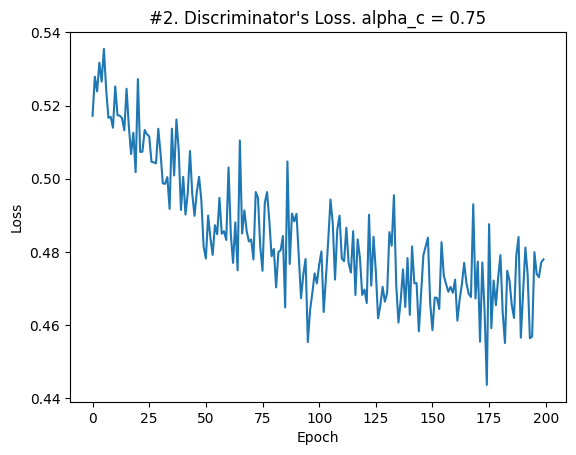

In [382]:
# Plot the discriminator's loss over epochs
plt.plot(H.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("#2. Discriminator's Loss. alpha_c = 0.75")
plt.show()

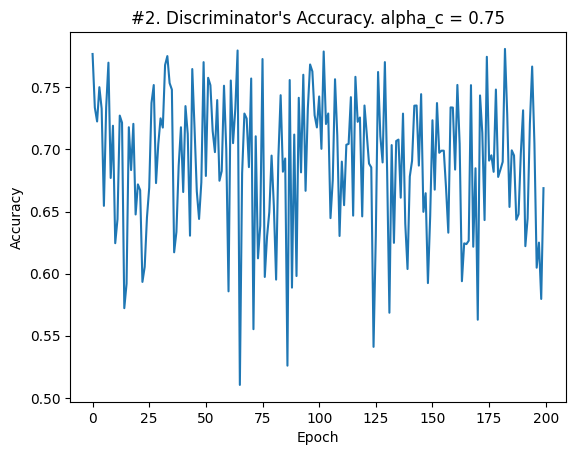

In [383]:
# Plot the discriminator's accuracy over epochs
plt.plot(H.history['custom_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("#2. Discriminator's Accuracy. alpha_c = 0.75")
plt.show()

In [385]:
from sklearn.metrics import roc_auc_score

print("Training Accuracy:", custom_accuracy(np.array(y_train, dtype=np.float32), qdisc_model.predict(train_quantum_data)).numpy())
print("Testing Accuracy", custom_accuracy(np.array(y_test, dtype=np.float32), qdisc_model.predict(test_quantum_data)).numpy())

print("Training AUC:", roc_auc_score(np.argmax(((y_train+1)/2)[:, :2], axis=1), (((qdisc_model.predict(train_quantum_data)+1)/2)[:, :2])[:, 1]))
print("Testing AUC:", roc_auc_score(np.argmax(((y_test+1)/2)[:, :2], axis=1), (((qdisc_model.predict(test_quantum_data)+1)/2)[:, :2])[:, 1]))

Training Accuracy: 0.76
Testing Accuracy 0.71
Training AUC: 0.8048
Testing AUC: 0.7912


### Conclusion: 

With a discriminator accuracy of approximately 75% for training and 72% for testing, accompanied by an AUC (Area Under the Curve) of around 80% for both training and testing, this model shows a reasonable ability to classify both real and fake data, as well as signal and background events. Moreover, it can generate quantum data similar to real quantum data. Nevertheless, there is still potential for performance enhancement.

* To improve the performance of the model, we can adjust the architecture of the Quantum Generator and Quantum Discriminator. Adding more layers could help better capture the data's characteristics and enhance generalization. Also, there are some approaches using the SWAP test to classify. 


* Given the small size of the training dataset (100 samples for training and 100 for testing), increasing the data could be beneficial. 


* Additionally, adjusting the model's architecture and optimizer learning rate could further enhance performance. Exploring regularization techniques and data preprocessing can also help prevent overfitting and improve model generalization.


* Moreover, an experiment could be conducted to compare the model's performance with and without entanglement layers to assess the impact of "quantumness". Eliminating these layers might streamline the model's architecture and simplify the quantum circuit's complexity. However, this alteration could affect the model's capability to capture intricate relationships among input variables. Conducting this comparison would provide deeper insights into the influence of entanglement layers on model performance and ascertain whether they are indispensable for achieving optimal results. It's worth noting that for some popular quantum neural network models, the presence or absence of quantumness doesn't significantly affect their performance [3].



#### References 

1. [K. Nakaji and N. Yamamoto, “Quantum semi-supervised generative adversarial network for enhanced data classification,” Oct. 2020.](https://arxiv.org/abs/2010.13727)
2. [P. L. Dallaire-Demers and N. Killoran, “Quantum generative adversarial networks,” Phys. Rev. A, vol. 98, no. 1, p. 012324, Jul. 2018.](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.98.012324)
3. [Joseph Bowles, Shahnawaz Ahmed, Maria Schuld. "Better than classical? The subtle art of benchmarking quantum machine learning models". Mar. 2024.](https://arxiv.org/abs/2403.07059)
